In [1]:
import sys
sys.path = ['/eos/user/d/dvalsecc/.local/lib/python3.9/site-packages'] + sys.path

In [1]:
import awkward as ak
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
import numpy as np
import pandas as pd
from coffea.util import load
import hist
import os
from pprint import pprint 
hep.style.use(hep.style.ROOT)
import vector
vector.register_awkward()

import hist
import numba

In [2]:
from coffea import processor
from coffea.processor import accumulate
from coffea.processor.accumulator import column_accumulator
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from distributed import Client


In [8]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/TTbar_MC_Run3_noise235fb_thres235fb/"
os.makedirs(output_folder,exist_ok=True)
input_folder_must = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTTo2L2Nu_powheg_pythia8_13p6TeV_PremixRun3PU40/RECO_Mustache_thres235fb/230308_163033"
input_folder_deep = "/eos/cms/store/group/dpg_ecal/alca_ecalcalib/bmarzocc/Clustering/TTTo2L2Nu_powheg_pythia8_13p6TeV_PremixRun3PU40/RECO_DeepSC_algoA_thres235fb/230308_155617"

In [9]:
dfM = uproot.lazy(f"{input_folder_must}/0000/output_1.root:recosimdumper/caloTree", num_workers=3)
dfD = uproot.lazy(f"{input_folder_deep}/0000/output_1.root:recosimdumper/caloTree", num_workers=3)

In [5]:
dfD = uproot.lazy(f"output_badder.root:recosimdumper/caloTree", num_workers=3)

In [11]:
dfD.fields

['eventId',
 'lumiId',
 'runId',
 'rho',
 'nVtx',
 'truePU',
 'obsPU',
 'genParticle_size',
 'genParticle_genMotherIndex',
 'genParticle_genDaughtersIndex',
 'genParticle_pdgId',
 'genParticle_status',
 'genParticle_energy',
 'genParticle_pt',
 'genParticle_eta',
 'genParticle_phi',
 'genParticle_pfCluster_dR_genScore_MatchedIndex',
 'genParticle_superCluster_dR_genScore_MatchedIndex',
 'pfCluster_rawEnergy',
 'pfCluster_energy',
 'pfCluster_rawPt',
 'pfCluster_pt',
 'pfCluster_eta',
 'pfCluster_phi',
 'pfCluster_ieta',
 'pfCluster_iphi',
 'pfCluster_iz',
 'pfCluster_nXtals',
 'pfCluster_etaWidth',
 'pfCluster_phiWidth',
 'pfCluster_e5x5',
 'pfCluster_e2x2Ratio',
 'pfCluster_e3x3Ratio',
 'pfCluster_eMaxRatio',
 'pfCluster_e2ndRatio',
 'pfCluster_eTopRatio',
 'pfCluster_eRightRatio',
 'pfCluster_eBottomRatio',
 'pfCluster_eLeftRatio',
 'pfCluster_e2x5MaxRatio',
 'pfCluster_e2x5TopRatio',
 'pfCluster_e2x5RightRatio',
 'pfCluster_e2x5BottomRatio',
 'pfCluster_e2x5LeftRatio',
 'pfCluster_s

In [4]:
@numba.njit
def genparticle_mother_pdgId(genparticle_mother_index, genparticle_pdgid,genparticle_status, builder):
    for mother_index,pdgId, status  in zip(genparticle_mother_index, genparticle_pdgid,genparticle_status):
        builder.begin_list()
        
        for i in range(len(pdgId)):
            if status[i]!=1 or abs(pdgId[i])!=11: continue
            builder.begin_record()
            builder.field('index').append(i)
            genpart_i = i
            while True:
                if mother_index[genpart_i] == -1:
                    builder.field("pdgId").append(pdgId[genpart_i])
                    break
                else:
                    genpart_i = mother_index[genpart_i]
            builder.end_record()
        builder.end_list()
    return builder

In [84]:
len(dfD.genParticle_pdgId[0])

10903

In [6]:
dfD.genParticle_statusFlag[(dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)][0].tolist()

[12673, 12352, 12352, 12352, 12352]

(array([38., 22., 65., 21., 19., 18.,  4.,  8.,  2.,  3.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

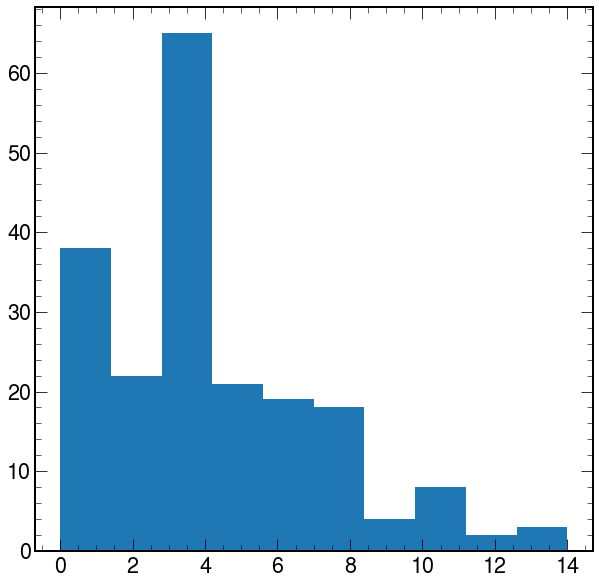

In [7]:
n_gen_electron = ak.sum((dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11), axis=1)

plt.hist(n_gen_electron)

(array([101.,   0.,   0.,  84.,   0.,   0.,  14.,   0.,   0.,   1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

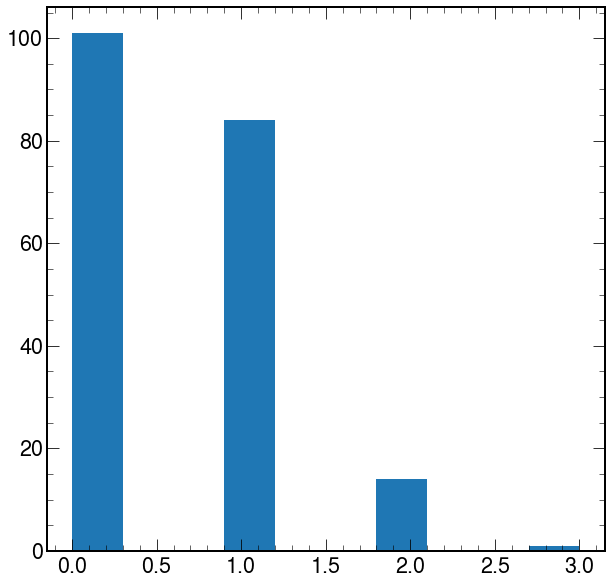

In [8]:
n_gen_electron = ak.sum((dfD.genParticle_status==1)&(dfD.genParticle_statusFlag&1==1)&(abs(dfD.genParticle_pdgId)==11), axis=1)

plt.hist(n_gen_electron)

In [29]:
ak.sum((dfD.genParticle_status==1), axis=1)

<Array [34, 40, 23, 36, 20, ... 19, 52, 31, 42] type='10 * int64'>

In [100]:
mother_pdgid = genparticle_mother_pdgId(dfD.genParticle_genMotherIndex, 
                         dfD.genParticle_pdgId,
                         dfD.genParticle_status,
                         ak.ArrayBuilder()).snapshot()


In [108]:
mother_pdgid[2]

<Array [{index: 1410, ... pdgId: 111}] type='5 * {"index": int64, "pdgId": int64}'>

In [11]:
local_index = ak.local_index(dfD.genParticle_status)
electrons = local_index[(dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)]

In [12]:
ev = 1
for i in electrons[ev]:
    while True:
        print(f"genpar: {i}, status {dfD.genParticle_status[ev][i]}, pdgid {dfD.genParticle_pdgId[ev][i]} \
        eta:{dfD.genParticle_eta[ev][i]:.3f} pt:{dfD.genParticle_pt[ev][i]:.3f} \
        isDecayedLeptonHadron: {dfD.genParticle_statusFlag[ev][i]&2==1} \
        isHardProcess: {dfD.genParticle_statusFlag[ev][i]&7==1}")
        if dfD.genParticle_genMotherIndex[ev][i] == -1:
            print("Reached the end")
            break
        else:
            i = dfD.genParticle_genMotherIndex[ev][i]

genpar: 59, status 1, pdgid 11         eta:-0.385 pt:15.293         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 57, status 23, pdgid 11         eta:-0.413 pt:15.888         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 47, status 52, pdgid -24         eta:-1.686 pt:64.993         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 44, status 22, pdgid -24         eta:-1.639 pt:70.603         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 34, status 62, pdgid -6         eta:-2.345 pt:61.751         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 18, status 44, pdgid -6         eta:-2.347 pt:61.656         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 15, status 44, pdgid -6         eta:-2.344 pt:61.926         isDecayedLeptonHadron: False         isHardProcess: True
genpar: 13, status 44, pdgid -6         eta:-2.348 pt:61.565         isDecayedLeptonHadron: False         isHardProce

# Matching genParticles to reco objects

In [10]:
gen_mask_ele = (dfD.genParticle_status==1)&(abs(dfD.genParticle_pdgId)==11)&(dfD.genParticle_statusFlag&1==1)
genParticles = ak.with_name(ak.zip({
    "pt": dfD.genParticle_pt[gen_mask_ele],
    "eta": dfD.genParticle_eta[gen_mask_ele],
    "phi": dfD.genParticle_phi[gen_mask_ele],
    "M": ak.zeros_like(dfD.genParticle_pt[gen_mask_ele])
}), name="Momentum4D")

In [11]:
sc = ak.with_name(ak.zip({
    "pt": dfD.superCluster_energy / np.cosh(dfD.superCluster_eta),
    "eta": dfD.pfCluster_eta[dfD.superCluster_seedIndex],  # seed Eta
    "phi": dfD.pfCluster_phi[dfD.superCluster_seedIndex],
    "E": dfD.superCluster_energy,
}), name="Momentum4D")

In [12]:
electrons = ak.with_name(ak.zip({
    "pt": dfD.patElectron_pt,
    "eta": dfD.patElectron_eta,
    "phi": dfD.patElectron_phi,
    "M": ak.zeros_like(dfD.patElectron_pt),
}), name="Momentum4D")

In [75]:
ak.num(sc)

<Array [3, 3, 7, 6, 5, 4, ... 6, 9, 7, 5, 4, 6] type='200 * int64'>

In [76]:
ak.num(genParticles)

<Array [9, 10, 5, 0, 13, 5, ... 20, 9, 9, 2, 5] type='200 * int64'>

### Matching

In [14]:
matched_sc, matched_genpart_sc, deltaR_sc, idx_sc, idx_genpart_sc, deltaR_masked_sc = get_unique_match(sc, genParticles, deltaRmax=0.2)
matched_ele, matched_genpart_ele, deltaR_ele, idx_ele, idx_genpart_ele, deltaR_masked_ele = get_unique_match(electrons, genParticles, deltaRmax=0.2)
is_genmatched_sc = ~ak.is_none(matched_genpart_sc, axis=1)
is_genmatched_ele = ~ak.is_none(matched_genpart_ele, axis=1)

In [64]:
matched_sc[2].tolist()

[{'pt': 79.38996124267578,
  'eta': -1.5297189950942993,
  'phi': 1.6658562421798706,
  'E': 191.86474609375}]

In [65]:
matched_genpart_sc[2].tolist()

[{'pt': 82.48982238769531,
  'eta': -1.5227717161178589,
  'phi': 1.676742672920227,
  'M': 0.0}]

(array([52., 56., 31., 15.,  7., 12.,  7.,  4.,  4.,  4.]),
 array([0.00096794, 0.01917825, 0.03738855, 0.05559886, 0.07380917,
        0.09201948, 0.11022979, 0.12844009, 0.1466504 , 0.16486071,
        0.18307102]),
 <BarContainer object of 10 artists>)

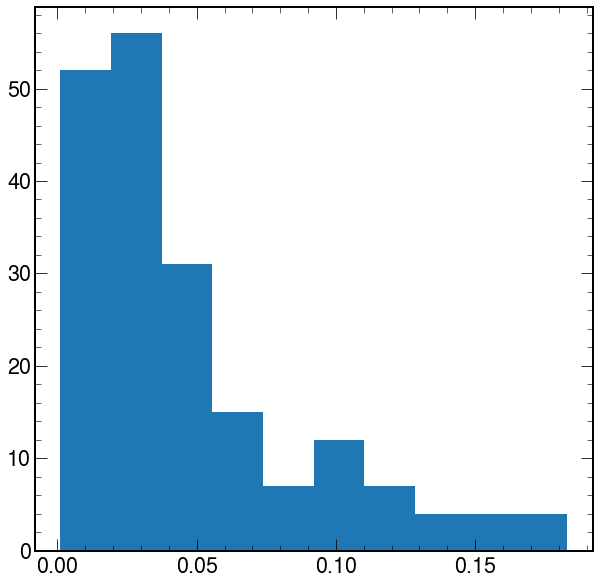

In [23]:
plt.hist(ak.flatten(deltaR_sc))

In [24]:
idx_genpart_sc

<Array [[0, None, None, ... 0, None, None]] type='200 * var * ?int64'>

## Prepare output

In [59]:
dfD.fields

['eventId',
 'lumiId',
 'runId',
 'rho',
 'nVtx',
 'truePU',
 'obsPU',
 'genParticle_size',
 'genParticle_genMotherIndex',
 'genParticle_genDaughtersIndex',
 'genParticle_pdgId',
 'genParticle_status',
 'genParticle_energy',
 'genParticle_pt',
 'genParticle_eta',
 'genParticle_phi',
 'genParticle_pfCluster_dR_genScore_MatchedIndex',
 'genParticle_superCluster_dR_genScore_MatchedIndex',
 'pfCluster_rawEnergy',
 'pfCluster_energy',
 'pfCluster_rawPt',
 'pfCluster_pt',
 'pfCluster_eta',
 'pfCluster_phi',
 'pfCluster_ieta',
 'pfCluster_iphi',
 'pfCluster_iz',
 'pfCluster_nXtals',
 'pfCluster_etaWidth',
 'pfCluster_phiWidth',
 'pfCluster_e5x5',
 'pfCluster_e2x2Ratio',
 'pfCluster_e3x3Ratio',
 'pfCluster_eMaxRatio',
 'pfCluster_e2ndRatio',
 'pfCluster_eTopRatio',
 'pfCluster_eRightRatio',
 'pfCluster_eBottomRatio',
 'pfCluster_eLeftRatio',
 'pfCluster_e2x5MaxRatio',
 'pfCluster_e2x5TopRatio',
 'pfCluster_e2x5RightRatio',
 'pfCluster_e2x5BottomRatio',
 'pfCluster_e2x5LeftRatio',
 'pfCluster_s

In [15]:
genParticle_fields = ["genParticle_eta","genParticle_phi","genParticle_pt","genParticle_pdgId"]
patElectron_fields = [f for f in dfD.fields if f.startswith("patElectron") if f not in ["patElectron_overlapPhotonIndices"]]
SC_fields = [f for f in dfD.fields if f.startswith("superCluster") and f not in ["superCluster_nXtals","superCluster_psCluster_energy",
                                                                                "superCluster_psCluster_eta","superCluster_psCluster_phi"]]

In [22]:
dfD.genParticle_energy[gen_mask_ele][~is_genmatched_sc]

<Array [[], [], [], [], ... [], [], [], []] type='200 * var * float32'>

In [67]:
output = {}

output["event_size_sc"] =  column_accumulator(ak.to_numpy(
                         ak.sum(is_genmatched_sc, axis=1), allow_missing=False))

output["event_size_ele"] =  column_accumulator(ak.to_numpy(
                         ak.sum(is_genmatched_ele, axis=1), allow_missing=False))

for k in ["obsPU", "truePU", "nVtx", "eventId", "runId"]:
    output[k] = column_accumulator(ak.to_numpy(dfD[k], allow_missing=False))
    
   
for k in genParticle_fields:
    output[k + "_sc"] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][gen_mask_ele][idx_genpart_sc[is_genmatched_sc]], axis=None),
                allow_missing=False))  
    
output["genParticle_index_sc"] = column_accumulator(ak.to_numpy(
                ak.flatten(idx_genpart_sc[is_genmatched_sc], axis=None), allow_missing=False))
output["genParticle_index_ele"] = column_accumulator(ak.to_numpy(
                ak.flatten(idx_genpart_ele[is_genmatched_ele], axis=None), allow_missing=False))
    
for k in genParticle_fields:
    output[k + "_ele"] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][gen_mask_ele][idx_genpart_ele[is_genmatched_ele]], axis=None),
                allow_missing=False))    
    
    
for k in SC_fields:
    output[k] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][idx_sc[is_genmatched_sc]], axis=None),
                allow_missing=False))
    
for k in patElectron_fields:
    output[k] =  column_accumulator(ak.to_numpy(
                ak.flatten(
                    dfD[k][idx_ele[is_genmatched_ele]], axis=None),
                allow_missing=False))
 

In [68]:
output

{'event_size_sc': column_accumulator(array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 1, 0,
        1, 1])),
 'event_size_ele': column_accumulator(array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 0,

In [174]:
output["event_size_sc"]

column_accumulator(array([1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 3, 3, 1, 1, 2, 1, 1, 2, 0,
       2, 2, 0, 0, 0, 1, 1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0,
       1, 2, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 2,
       1, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 0, 4, 1, 0, 2, 3, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 4, 1, 0, 1, 0, 3, 1, 2, 1, 2, 2, 2, 1, 1,
       0, 2, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 2, 0, 4, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0,
       2, 2, 0, 0, 1, 0, 1, 3, 0, 3, 2, 1, 0, 1, 1, 2, 2, 3, 2, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 0, 0, 2, 1, 0,
       2, 1]))

# Coffea processor

### Dask cluster

In [3]:
from dask_lxplus import CernCluster
import socket
n_port = 8786

log_folder = "/afs/cern.ch/work/d/dvalsecc/private/Clustering_tools/DeepSuperCluster/Evaluation/GraphSC/reco_comparison/ttbar_analysis/condor_log"

# Creating a CERN Cluster, special configuration for dask-on-lxplus
cluster = CernCluster(
    cores=1,
    memory="2000MB",
    disk="5GB",
    image_type="singularity",
    worker_image="/cvmfs/unpacked.cern.ch/gitlab-registry.cern.ch/batch-team/dask-lxplus/lxdask-cc7:latest",
    death_timeout="3600",
    scheduler_options={"port": n_port, "host": socket.gethostname()},
    log_directory = log_folder,
    # shared_temp_directory="/tmp"
    job_extra={
        "log": f"{log_folder}/dask_job_output.log",
        "output": f"{log_folder}/dask_job_output.out",
        "error": f"{log_folder}/dask_job_output.err",
        "should_transfer_files": "Yes",
        "when_to_transfer_output": "ON_EXIT",
        "+JobFlavour": f'"microcentury"'
    },
    env_extra=["source /afs/cern.ch/work/d/dvalsecc/private/Clustering_tools/DeepSuperCluster/myenv/bin/activate"],
)

cluster.scale(80)
client = Client(cluster)
client.wait_for_workers(1)

/usr/local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
class TTbarProcessorTest(processor.ProcessorABC):
    def __init__(self):
        pass
    
    def process(self, events):
        dataset = events.metadata['dataset']
        file = events.metadata["filename"]
        
        return {dataset:
               {"N_sc": column_accumulator(ak.to_numpy(ak.num(events.superCluster_energy, axis=1)))}}
    
    
    def postprocess(self, accumulator):
        pass

In [4]:
from collections.abc import Iterable
import numpy as np
import awkward as ak
import numba


@numba.njit
def get_matching_pairs_indices(idx_1, idx_2, builder, builder2):
    for ev_q, ev_j in zip(idx_1, idx_2):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for i, (q, j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done:
                if j not in j_done:
                    builder.append(i)
                    q_done.append(q)
                    j_done.append(j)
                else:
                    builder2.append(i)
        builder.end_list()
        builder2.end_list()
    return builder, builder2


# This function takes as arguments the indices of two collections of objects that have been
# previously matched. The idx_matched_obj2 indices are supposed to be ordered but they can have missing elements.
# The idx_matched_obj indices are matched to the obj2 ones and no order is required on them.
# The function return an array of the dimension of the maxdim_obj2 (akward dimensions) with the indices of idx_matched_obk
# matched to the elements in idx_matched_obj2. None values are included where
# no match has been found.
@numba.njit
def get_matching_objects_indices_padnone(
    idx_matched_obj, idx_matched_obj2, maxdim_obj2, deltaR, builder, builder2, builder3
):
    for ev1_match, ev2_match, nobj2, dr in zip(
        idx_matched_obj, idx_matched_obj2, maxdim_obj2, deltaR
    ):
        # print(ev1_match, ev2_match)
        builder.begin_list()
        builder2.begin_list()
        builder3.begin_list()
        row1_length = len(ev1_match)
        missed = 0
        for i in range(nobj2):
            # looping on the max dimension of collection 2 and checking if the current index i
            # is matched, e.g is part of ev2_match vector.
            if i in ev2_match:
                # if this index is matched, then take the ev1_match and deltaR results
                # print(i, row1_length)
                builder2.append(i)
                if i - missed < row1_length:
                    builder.append(ev1_match[i - missed])
                    builder3.append(dr[i - missed])
            else:
                # If it is missing a None is added and the missed  is incremented
                # so that the next matched one will get the correct element assigned.
                builder.append(None)
                builder2.append(None)
                builder3.append(None)
                missed += 1
        builder.end_list()
        builder2.end_list()
        builder3.end_list()
    return builder, builder2, builder3


def metric_pt(obj, obj2):
    return abs(obj.pt - obj2.pt)


def get_unique_match(obj1, obj2, deltaRmax=0.2):
    a, b = ak.unzip(
       ak.cartesian([obj1, obj2], axis=1, nested=True)
        )
    deltaR = ak.flatten(a.deltaR(b), axis=2)
    # Keeping only the pairs with a deltaR min
    maskDR = deltaR < deltaRmax

    # Get the indexing to sort the pairs sorted by deltaR without any cut
    idx_pairs_sorted = ak.argsort(deltaR, axis=1)
    pairs = ak.argcartesian([obj1, obj2])
    # Sort all the collection over pairs by deltaR
    pairs_sorted = pairs[idx_pairs_sorted]
    deltaR_sorted = deltaR[idx_pairs_sorted]
    maskDR_sorted = maskDR[idx_pairs_sorted]
    idx_obj, idx_obj2 = ak.unzip(pairs_sorted)

    # Now get only the matching indices by looping over the pairs in order of deltaR.
    # The result contains the list of pairs that are considered valid
    _idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(
        ak.without_parameters(idx_obj, behavior={}),
        ak.without_parameters(idx_obj2, behavior={}),
        ak.ArrayBuilder(),
        ak.ArrayBuilder(),
    )

    idx_matched_pairs = _idx_matched_pairs.snapshot()
    # The indices related to the invalid jet matches are skipped
    # idx_missed_pairs  = _idx_missed_pairs.snapshot()
    # Now let's get get the indices of the objects corresponding to the valid pairs
    idx_matched_obj = idx_obj[idx_matched_pairs]
    idx_matched_obj2 = idx_obj2[idx_matched_pairs]
    # Getting also deltaR and maskDR of the valid pairs
    deltaR_matched = deltaR_sorted[idx_matched_pairs]
    maskDR_matched = maskDR_sorted[idx_matched_pairs]



    # We get the indices needed to reorder the second collection
    # and we use them to re-order also the other collection (same dimension of the valid pairs)
    obj2_order = ak.argsort(idx_matched_obj2)
    idx_obj_obj2sorted = idx_matched_obj[obj2_order]
    idx_obj2_obj2sorted = idx_matched_obj2[obj2_order]
    deltaR_obj2sorted = deltaR_matched[obj2_order]
    maskDR_obj2sorted = maskDR_matched[obj2_order]
    # Here we apply the deltaR + pT requirements on the objects and on deltaR
    idx_obj_masked = idx_obj_obj2sorted[maskDR_obj2sorted]
    idx_obj2_masked = idx_obj2_obj2sorted[maskDR_obj2sorted]
    # Getting also the deltaR of the masked pairs
    deltaR_masked = deltaR_obj2sorted[maskDR_obj2sorted]
    # N.B. We are still working only with indices not final objects

    # Now we have the object in the collection 1 ordered as the collection 2,
    # but we would like to have an ak.Array of the dimension of the collection 2, with "None"
    # in the places where there is not matching.
    # We need a special function for that, building the ak.Array of object from collection 1, with the dimension of collection 2, with None padding.
    (
        _idx_obj_padnone,
        _idx_obj2_padnone,
        _deltaR_padnone,
    ) = get_matching_objects_indices_padnone(
        ak.without_parameters(idx_obj_masked, behavior={}),
        ak.without_parameters(idx_obj2_masked, behavior={}),
        ak.without_parameters(ak.num(obj2), behavior={}),
        ak.without_parameters(deltaR_masked, behavior={}),
        ak.ArrayBuilder(),
        ak.ArrayBuilder(),
        ak.ArrayBuilder(),
    )
    idx_obj_padnone = _idx_obj_padnone.snapshot()
    idx_obj2_padnone = _idx_obj2_padnone.snapshot()
    deltaR_padnone = _deltaR_padnone.snapshot()

    # Finally the objects are sliced through the padded indices
    # In this way, to a None entry in the indices will correspond a None entry in the object
    matched_obj = obj1[idx_obj_padnone]
    matched_obj2 = obj2[idx_obj2_padnone]

    return (
        matched_obj,
        matched_obj2,
        deltaR_padnone,
        idx_obj_padnone,
        idx_obj2_padnone,
        deltaR_masked
    )



In [5]:
class TTbarProcessor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        file = events.metadata["filename"]
        
        g = file.split("/")
        runId = int("1" + g[-2] + "_" + g[-1].replace("output_","").replace(".root","") )
        
        vector.register_awkward()
     
        gen_mask_ele = (events.genParticle_status==1)&(abs(events.genParticle_pdgId)==11)&(events.genParticle_statusFlag&1==1)
        genParticles = ak.with_name(ak.zip({
                "pt": events.genParticle_pt[gen_mask_ele],
                "eta": events.genParticle_eta[gen_mask_ele],
                "phi": events.genParticle_phi[gen_mask_ele],
                "M": ak.zeros_like(events.genParticle_pt[gen_mask_ele])
            }), name="Momentum4D")

        sc = ak.with_name(ak.zip({
            "pt": events.superCluster_energy / np.cosh(events.superCluster_eta),
            "eta": events.pfCluster_eta[events.superCluster_seedIndex],  # seed Eta
            "phi": events.pfCluster_phi[events.superCluster_seedIndex],
            "E": events.superCluster_energy,
        }), name="Momentum4D")
        
        
        electrons = ak.with_name(ak.zip({
            "pt": events.patElectron_pt,
            "eta": events.patElectron_eta,
            "phi": events.patElectron_phi,
            "M": ak.zeros_like(events.patElectron_pt),
        }), name="Momentum4D")
        
        matched_sc, matched_genpart_sc, deltaR_sc, idx_sc, idx_genpart_sc, deltaR_masked_sc = get_unique_match(sc, genParticles, deltaRmax=0.2)
        matched_ele, matched_genpart_ele, deltaR_ele, idx_ele, idx_genpart_ele, deltaR_masked_ele = get_unique_match(electrons, genParticles, deltaRmax=0.2)
        is_genmatched_sc = ~ak.is_none(matched_genpart_sc, axis=1)
        is_genmatched_ele = ~ak.is_none(matched_genpart_ele, axis=1)
        
        
        genParticle_fields = ["genParticle_eta","genParticle_phi","genParticle_pt","genParticle_pdgId"]
        patElectron_fields = [f for f in events.fields if f.startswith("patElectron") if f not in ["patElectron_overlapPhotonIndices"]]
        SC_fields = [f for f in events.fields if f.startswith("superCluster") and f not in ["superCluster_nXtals","superCluster_psCluster_energy",
                                                                                        "superCluster_psCluster_eta","superCluster_psCluster_phi"]]
        
        output = {}

        output["N_genmatched_sc"] =  column_accumulator(ak.to_numpy(
                                 ak.sum(is_genmatched_sc, axis=1), allow_missing=False))

        output["N_genmatched_ele"] =  column_accumulator(ak.to_numpy(
                                 ak.sum(is_genmatched_ele, axis=1), allow_missing=False))
        
        output["N_nongenmatched_sc"] =  column_accumulator(ak.to_numpy(
                                 ak.sum(~is_genmatched_sc, axis=1), allow_missing=False))

        output["N_nongenmatched_ele"] =  column_accumulator(ak.to_numpy(
                                 ak.sum(~is_genmatched_ele, axis=1), allow_missing=False))

        for k in ["obsPU", "truePU", "nVtx", "eventId", ]:
            data_struct = ak.ones_like(idx_genpart_sc[is_genmatched_sc])
            output[k+"_sc"] = column_accumulator(ak.to_numpy(
                ak.flatten(events[k]*data_struct), allow_missing=False))
            output["runId_sc"] = column_accumulator(ak.to_numpy(
                ak.flatten(runId*data_struct), allow_missing=False))
            
            data_struct = ak.ones_like(idx_genpart_ele[is_genmatched_ele])
            output[k+"_ele"] = column_accumulator(ak.to_numpy(
                ak.flatten(events[k]*data_struct), allow_missing=False))
            output["runId_ele"] = column_accumulator(ak.to_numpy(
                ak.flatten(runId*data_struct), allow_missing=False))
            
            
        for k in genParticle_fields:
            output[k + "_sc"] =  column_accumulator(ak.to_numpy(
                        ak.flatten(
                            events[k][gen_mask_ele][idx_genpart_sc[is_genmatched_sc]], axis=None),
                        allow_missing=False))  
            output[k + "_ele"] =  column_accumulator(ak.to_numpy(
                        ak.flatten(
                            events[k][gen_mask_ele][idx_genpart_ele[is_genmatched_ele]], axis=None),
                        allow_missing=False))  
            
            # Saving also the non matched genParticle
            output[k +"_notmatched_sc"] = column_accumulator(ak.to_numpy(
                    ak.flatten(events[k][gen_mask_ele][~is_genmatched_sc], axis=None
                    ), allow_missing=False))
            
            output[k +"_notmatched_ele"] = column_accumulator(ak.to_numpy(
                    ak.flatten(events[k][gen_mask_ele][~is_genmatched_sc], axis=None
                    ), allow_missing=False))
        

        output["genParticle_index_sc"] = column_accumulator(ak.to_numpy(
                        ak.flatten(idx_genpart_sc[is_genmatched_sc], axis=None), allow_missing=False))
        output["genParticle_index_ele"] = column_accumulator(ak.to_numpy(
                        ak.flatten(idx_genpart_ele[is_genmatched_ele], axis=None), allow_missing=False))

        

        for k in SC_fields:
            output[k] =  column_accumulator(ak.to_numpy(
                        ak.flatten(
                            events[k][idx_sc[is_genmatched_sc]], axis=None),
                        allow_missing=False))

        for k in patElectron_fields:
            output[k] =  column_accumulator(ak.to_numpy(
                        ak.flatten(
                            events[k][idx_ele[is_genmatched_ele]], axis=None),
                        allow_missing=False))
    

        return {
            dataset: output
                
        }

    def postprocess(self, accumulator):
        pass

In [9]:
from glob import glob
fileset = {
    "DeepSC": glob(input_folder_deep+"/*/*.root", recursive=True),
    "Mustache": glob(input_folder_must+"/*/*.root", recursive=True)
}

fileset_small = {
    "DeepSC": glob(input_folder_deep+"/*/*.root", recursive=True)[0:10],
    "Mustache": glob(input_folder_must+"/*/*.root", recursive=True)[0:10]
}

In [10]:
iterative_run = processor.Runner(
     executor = processor.IterativeExecutor(compression=None),
     schema=BaseSchema,
     chunksize=200
)
out = iterative_run(
     fileset_small,
     treename="recosimdumper/caloTree",
     processor_instance=TTbarProcessor(),
 )

Preprocessing:   0%|          | 0/20 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

In [16]:
iterative_run = processor.Runner(
            executor = processor.DaskExecutor(
                client=client,
            ),
            schema=BaseSchema,
            chunksize=200,
        )

out = iterative_run(
    fileset,
    treename="recosimdumper/caloTree",
    processor_instance=TTbarProcessor(),
)

In [17]:
from coffea.util import save, load

In [18]:
save(out, "output.coffea")

In [19]:
out["DeepSC"]["runId_sc"]

column_accumulator(array([  100001,   100001,   100001, ..., 10000298, 10000298, 10000298]))

In [26]:
out["DeepSC"].keys()

dict_keys(['N_genmatched_sc', 'N_genmatched_ele', 'N_nongenmatched_sc', 'N_nongenmatched_ele', 'obsPU_sc', 'runId_sc', 'obsPU_ele', 'runId_ele', 'truePU_sc', 'truePU_ele', 'nVtx_sc', 'nVtx_ele', 'eventId_sc', 'eventId_ele', 'genParticle_eta_sc', 'genParticle_eta_ele', 'genParticle_eta_notmatched_sc', 'genParticle_eta_notmatched_ele', 'genParticle_phi_sc', 'genParticle_phi_ele', 'genParticle_phi_notmatched_sc', 'genParticle_phi_notmatched_ele', 'genParticle_pt_sc', 'genParticle_pt_ele', 'genParticle_pt_notmatched_sc', 'genParticle_pt_notmatched_ele', 'genParticle_pdgId_sc', 'genParticle_pdgId_ele', 'genParticle_pdgId_notmatched_sc', 'genParticle_pdgId_notmatched_ele', 'genParticle_index_sc', 'genParticle_index_ele', 'superCluster_seedRawId', 'superCluster_rawEnergy', 'superCluster_rawESEnergy', 'superCluster_energy', 'superCluster_eta', 'superCluster_phi', 'superCluster_etaWidth', 'superCluster_phiWidth', 'superCluster_R', 'superCluster_nPFClusters', 'superCluster_ieta', 'superCluster_i

In [43]:
np.sum(out["DeepSC"]["N_nongenmatched_ele"].value)

36817

In [42]:
np.sum(out["DeepSC"]["N_genmatched_ele"].value)

165318

In [35]:
13960 / 188175

0.07418626278729906

In [39]:
np.sum(out["Mustache"]["N_nongenmatched_ele"].value)

36639

In [40]:
np.sum(out["Mustache"]["N_genmatched_ele"].value)

165349

In [41]:
36639 / 165349

0.2215858577917012

In [ ]:
out["DeepSC"]["genParticle_index_sc"]

In [ ]:
cluster.close()